In [13]:
import sys
sys.path.append('../')

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import akshare as ak
import json
import os
import time
import sqlite3

from datetime import datetime
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
from database.downloader.downloader_base import DownloaderBase
import database.database_config as db_config

pd.options.display.max_rows=None
pd.options.display.max_columns=None

In [14]:
db_conn = sqlite3.connect('../database/hh_quant.db')
db_downloader = DownloaderBase(db_conn, db_config)

In [15]:
# stock_code_list = ak.stock_info_a_code_name()['code'] # 获取A股所有股票列表
stock_code_list = ak.index_stock_cons("000016")['品种代码'].tolist() # 获取中证50的股票代码列表
# stock_code_list = ak.index_stock_cons("000905")['品种代码'].tolist() # 获取中证500的股票代码列表
# stock_code_list = set(ak.index_stock_cons("000300")['品种代码'].tolist()) # 获取沪深300的股票代码列表
print(len(stock_code_list))

50


In [16]:
def build_label(dataframe):
    N = 5 # 最大持仓周期 = N天，第N+1天开盘卖出
    df = dataframe.copy()
    # 标签构建
    df['future_return'] = df['open'].shift(-N-1) / df['open'].shift(-1) - 1 # 计算第N日收益率
    # 极值处理
    df['future_return'] = np.clip(
        df['future_return'], 
        np.nanquantile(df[df['future_return'] != 0]['future_return'], 0.01), 
        np.nanquantile(df[df['future_return'] != 0]['future_return'], 0.99),
        )
    # 过滤一字涨停情况
    df = df[df['high'].shift(-1) != df['low'].shift(-1)]
    return df[['datetime', 'future_return']]

stock_df_list = []
for stock_code in tqdm(stock_code_list):
    stock_data = db_downloader._download_stock_history_info(stock_code)
    stock_label = build_label(stock_data)
    stock_factor_date = db_downloader._download_stock_factor_date_info()
    stock_factor_qlib = db_downloader._download_stock_factor_qlib_info(stock_code)
    stock_df = stock_data.merge(stock_label, on=['datetime']).merge(stock_factor_date, on=['datetime']).merge(stock_factor_qlib, on=['stock_code', 'datetime'])
    stock_df = stock_df.dropna()
    if not stock_df.empty:
        stock_df_list.append(stock_df)

len(stock_df_list)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:18<00:00,  2.65it/s]


50

In [17]:
df = pd.concat(stock_df_list)
# df.head()
# print([i for i in df.columns])

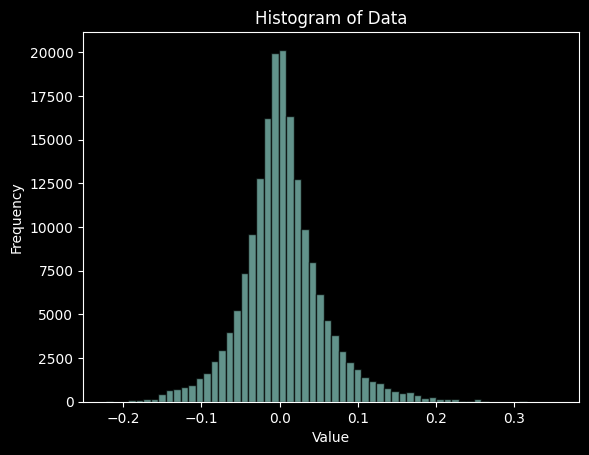

In [18]:
def plot_series_dist(series):
    import pandas as pd
    import matplotlib.pyplot as plt
    %matplotlib inline
    # 假设您有一个名为data的pandas Series
    data = series
    # 使用matplotlib画直方图
    plt.hist(data, bins=60, edgecolor='k', alpha=0.7)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Data')
    plt.show()

plot_series_dist(df['future_return'])

In [19]:
# from sklearn.preprocessing import StandardScaler
# ss = StandardScaler()

# series_reshape = df['future_return'].values.reshape(-1, 1)
# scaled_data = ss.fit_transform(series_reshape)
# scaled_series = pd.Series(scaled_data.flatten())
# plot_series_dist(scaled_series)

# df['future_return'] = scaled_series

## 使用Tensorflow

In [20]:
# 使用tensorflow处理原始数据
import numpy as np
import pandas as pd
import tensorflow as tf
print(tf.__version__)

2024-03-11 18:09:37.317650: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.15.0


In [22]:
backtest_start_date = datetime.strptime('20200101', '%Y%m%d')
backtest_end_date = datetime.strptime('20240101', '%Y%m%d')
val_start_date = backtest_start_date
train_period = 4 # year
update_period = 3 # month

rolling_training_flag = True

while rolling_training_flag:
    val_end_date = val_start_date + relativedelta(months=update_period) - relativedelta(days=1)
    if val_start_date < backtest_end_date:
        train_start_date = val_start_date - relativedelta(years=train_period)
        train_end_date = val_start_date - relativedelta(days=1)
        print(f"train_start: {train_start_date}, train_end: {train_end_date}, val_start: {val_start_date}, val_end: {val_end_date}")
         # 在这里处理滚动训练流程 ...
        val_start_date += relativedelta(months=3) 
    else:
        rolling_training_flag=False # 结束滚动训练

train_start: 2016-01-01 00:00:00, train_end: 2019-12-31 00:00:00, val_start: 2020-01-01 00:00:00, val_end: 2020-03-31 00:00:00
train_start: 2016-04-01 00:00:00, train_end: 2020-03-31 00:00:00, val_start: 2020-04-01 00:00:00, val_end: 2020-06-30 00:00:00
train_start: 2016-07-01 00:00:00, train_end: 2020-06-30 00:00:00, val_start: 2020-07-01 00:00:00, val_end: 2020-09-30 00:00:00
train_start: 2016-10-01 00:00:00, train_end: 2020-09-30 00:00:00, val_start: 2020-10-01 00:00:00, val_end: 2020-12-31 00:00:00
train_start: 2017-01-01 00:00:00, train_end: 2020-12-31 00:00:00, val_start: 2021-01-01 00:00:00, val_end: 2021-03-31 00:00:00
train_start: 2017-04-01 00:00:00, train_end: 2021-03-31 00:00:00, val_start: 2021-04-01 00:00:00, val_end: 2021-06-30 00:00:00
train_start: 2017-07-01 00:00:00, train_end: 2021-06-30 00:00:00, val_start: 2021-07-01 00:00:00, val_end: 2021-09-30 00:00:00
train_start: 2017-10-01 00:00:00, train_end: 2021-09-30 00:00:00, val_start: 2021-10-01 00:00:00, val_end: 2021

In [24]:
# 6. 选择固定时间区间的数据(训练数据=4年，后续滚动窗口=3个月)
train_start_date = pd.to_datetime('2016-01-01')
train_end_date = pd.to_datetime('2019-12-31')
val_start_date = pd.to_datetime('2020-01-01')
val_end_date = pd.to_datetime('2020-03-31')

train_data = df[(pd.to_datetime(df['datetime']) >= train_start_date) & (pd.to_datetime(df['datetime']) <= train_end_date)]
validation_data = df[(pd.to_datetime(df['datetime']) >= val_start_date) & (pd.to_datetime(df['datetime']) <= val_end_date)]

print(f"train_data_size: {train_data.shape}")
print(f"validation_data_size: {validation_data.shape}")

train_data_size: (40395, 199)
validation_data_size: (2572, 199)


In [25]:
def transfer_data_type(df, columns, dtype):
    for col in columns:
        df[col] = df[col].astype(dtype)
    return df

def get_numeric_boundaries(series, num_bins=30):
    if series.nunique() < num_bins:
        boundaries = sorted(series.unique())
    else:
        boundaries = pd.qcut(series, num_bins, retbins=True, duplicates='drop')[1].tolist()
    return boundaries

In [26]:
# TARGET_FEATURE_NAME = ["future_return", "future_label"] # 多任务模型还需要再优化
TARGET_FEATURE_NAME = ["future_return"]

NUMERIC_FEATURES = ['KMID', 'KLEN', 'KMID2', 'KUP', 'KUP2', 'KLOW', 'KLOW2', 'KSFT', 'KSFT2', 'OPEN0', 'OPEN1', 'OPEN2', 'OPEN3', 'OPEN4', 'HIGH0', 'HIGH1', 'HIGH2', 'HIGH3', 'HIGH4', 'LOW0', 'LOW1', 'LOW2', 'LOW3', 'LOW4', 'CLOSE0', 'CLOSE1', 'CLOSE2', 'CLOSE3', 'CLOSE4', 'VOLUME0', 'VOLUME1', 'VOLUME2', 'VOLUME3', 'VOLUME4', 'ROC5', 'ROC10', 'ROC20', 'ROC30', 'ROC60', 'MAX5', 'MAX10', 'MAX20', 'MAX30', 'MAX60', 'MIN5', 'MIN10', 'MIN20', 'MIN30', 'MIN60', 'MA5', 'MA10', 'MA20', 'MA30', 'MA60', 'STD5', 'STD10', 'STD20', 'STD30', 'STD60', 'BETA5', 'BETA10', 'BETA20', 'BETA30', 'BETA60', 'RSQR5', 'RSQR10', 'RSQR20', 'RSQR30', 'RSQR60', 'RESI5', 'RESI10', 'RESI20', 'RESI30', 'RESI60', 'QTLU5', 'QTLU10', 'QTLU20', 'QTLU30', 'QTLU60', 'QTLD5', 'QTLD10', 'QTLD20', 'QTLD30', 'QTLD60', 'TSRANK5', 'TSRANK10', 'TSRANK20', 'TSRANK30', 'TSRANK60', 'RSV5', 'RSV10', 'RSV20', 'RSV30', 'RSV60', 'IMAX5', 'IMAX10', 'IMAX20', 'IMAX30', 'IMAX60', 'IMIN5', 'IMIN10', 'IMIN20', 'IMIN30', 'IMIN60', 'IMXD5', 'IMXD10', 'IMXD20', 'IMXD30', 'IMXD60', 'CORR5', 'CORR10', 'CORR20', 'CORR30', 'CORR60', 'CORD5', 'CORD10', 'CORD20', 'CORD30', 'CORD60', 'CNTP5', 'CNTP10', 'CNTP20', 'CNTP30', 'CNTP60', 'CNTN5', 'CNTN10', 'CNTN20', 'CNTN30', 'CNTN60', 'CNTD5', 'CNTD10', 'CNTD20', 'CNTD30', 'CNTD60', 'SUMP5', 'SUMP10', 'SUMP20', 'SUMP30', 'SUMP60', 'SUMN5', 'SUMN10', 'SUMN20', 'SUMN30', 'SUMN60', 'SUMD5', 'SUMD10', 'SUMD20', 'SUMD30', 'SUMD60', 'VMA5', 'VMA10', 'VMA20', 'VMA30', 'VMA60', 'VSTD5', 'VSTD10', 'VSTD20', 'VSTD30', 'VSTD60', 'WVMA5', 'WVMA10', 'WVMA20', 'WVMA30', 'WVMA60', 'VSUMP5', 'VSUMP10', 'VSUMP20', 'VSUMP30', 'VSUMP60', 'VSUMN5', 'VSUMN10', 'VSUMN20', 'VSUMN30', 'VSUMN60', 'VSUMD5', 'VSUMD10', 'VSUMD20', 'VSUMD30', 'VSUMD60']
INTEGER_CATEGORICAL_FEATURES = ['weekday', 'day_of_month', 'month']
STRING_CATEGORICAL_FEATURES = ['day_of_week', 'season']

train_data = transfer_data_type(train_data, NUMERIC_FEATURES, 'float32')
train_data = transfer_data_type(train_data, INTEGER_CATEGORICAL_FEATURES, 'int32')
train_data = transfer_data_type(train_data, STRING_CATEGORICAL_FEATURES, 'string')
validation_data = transfer_data_type(validation_data, NUMERIC_FEATURES, 'float32')
validation_data = transfer_data_type(validation_data, INTEGER_CATEGORICAL_FEATURES, 'int64')
validation_data = transfer_data_type(validation_data, STRING_CATEGORICAL_FEATURES, 'string')

NUMERIC_FEATURES_WITH_BOUNDARIES = {k: list(get_numeric_boundaries(train_data[k])) for k in NUMERIC_FEATURES}
INTEGER_CATEGORICAL_FEATURES_WITH_VOCAB = {k: list(train_data[k].unique()) for k in INTEGER_CATEGORICAL_FEATURES}
STRING_CATEGORICAL_FEATURES_WITH_VOCAB = {k: list(train_data[k].unique()) for k in STRING_CATEGORICAL_FEATURES}

FEATURE_NAMES = NUMERIC_FEATURES + INTEGER_CATEGORICAL_FEATURES + STRING_CATEGORICAL_FEATURES

In [27]:
def df_to_dataset(dataframe, feature_cols, label_cols, shuffle=True, batch_size=32):
  features = dataframe[feature_cols]
  labels = [dataframe[label_col] for label_col in label_cols]
  ds = tf.data.Dataset.from_tensor_slices((dict(features), tuple(labels)))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(features))
  ds = ds.batch(batch_size)
  return ds

batch_size = 32
train_ds = df_to_dataset(train_data, FEATURE_NAMES, TARGET_FEATURE_NAME, shuffle=True, batch_size=batch_size)
val_ds = df_to_dataset(validation_data, FEATURE_NAMES, TARGET_FEATURE_NAME, shuffle=False, batch_size=batch_size)

In [29]:
# for features, labels in val_ds.take(1):
#     print(labels)

In [30]:
class Senet(tf.keras.layers.Layer):
    def __init__(self, reduction_ratio=3, seed=1024, **kwargs):
        super(Senet, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio
        self.seed = seed  

    def build(self, input_shape):
        self.field_size = len(input_shape)
        self.reduction_size = max(1, self.field_size // self.reduction_ratio)
        self.scale_layer = tf.keras.layers.Dense(units=self.reduction_size, activation='relu')
        self.expand_layer = tf.keras.layers.Dense(units=self.field_size, activation='relu')
        super(Senet, self).build(input_shape)

    def call(self, inputs, training=False):
        # print(f"Senet Is Training Mode: {training}")
        inputs = [tf.expand_dims(i, axis=1) for i in inputs]
        inputs = tf.concat(inputs, axis=1) # [B, N, dim]
        Z = tf.reduce_mean(inputs, axis=-1) # [B, N]
        A_1 = self.scale_layer(Z, training=training) # [B, X]
        A_2 = self.expand_layer(A_1, training=training) # [B, N]
        scale_inputs = tf.multiply(inputs, tf.expand_dims(A_2, axis=-1))
        output = scale_inputs + inputs # skip-connection
        return output # [B, N, dim]

    def get_config(self):
        config = super(Senet, self).get_config()
        config.update({
            'reduction_ratio': self.reduction_ratio,
            'seed': self.seed
        })
        return config

class Dnn(tf.keras.layers.Layer):
    def __init__(self, hidden_units=[64,32], activation="relu", dropout_rate=0.2, use_bn=True, seed=1024, **kwargs):
        super(Dnn, self).__init__(**kwargs)
        self.hidden_units = hidden_units
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.use_bn = use_bn
        self.seed = seed
        self.dense_layers = []
        self.dropout_layers = []
        self.bn_layers = []
        
    def build(self, input_shape):
        for units in self.hidden_units:
            self.dense_layers.append(tf.keras.layers.Dense(units=units, activation=self.activation))
            self.dropout_layers.append(tf.keras.layers.Dropout(rate=self.dropout_rate, seed=self.seed))
            if self.use_bn:
                self.bn_layers.append(tf.keras.layers.BatchNormalization())
        super(Dnn, self).build(input_shape)  # Be sure to call this at the end
    
    def call(self, inputs, training=False):
        # print(f"Dnn Is Training Mode: {training}")
        x = inputs
        for i in range(len(self.hidden_units)):
            x = self.dense_layers[i](x)
            if self.use_bn:
                x = self.bn_layers[i](x, training=training)
            x = self.dropout_layers[i](x, training=training)
        return x

    def get_config(self):
        config = super(Dnn, self).get_config()
        config.update({
            'hidden_units': self.hidden_units,
            'activation': self.activation,
            'dropout_rate': self.dropout_rate,
            'use_bn': self.use_bn,
            'seed': self.seed
        })
        return config

In [31]:
class QuantModel(tf.keras.Model):
	def __init__(self, config, **kwargs):
		super(QuantModel, self).__init__(**kwargs)
		self.config = config

		# 添加属性来存储预定义的层
		self.lookup_layers = {}
		self.embedding_layers = {}

        # 创建连续特征的离散化层和嵌入层
		for feature_name, boundaries in self.config.get("numeric_features_with_boundaries").items():
			self.lookup_layers[feature_name] = tf.keras.layers.Discretization(bin_boundaries=boundaries, output_mode='int', name=f'{feature_name}_lookup')
			self.embedding_layers[feature_name] = tf.keras.layers.Embedding(input_dim=len(boundaries) + 1, output_dim=self.config.get("feature_embedding_dims", 6), name=f'{feature_name}_embedding')
        # 创建整数特征的查找层和嵌入层
		for feature_name, vocab in self.config.get("integer_categorical_features_with_vocab").items():
			self.lookup_layers[feature_name] = tf.keras.layers.IntegerLookup(vocabulary=vocab, name=f'{feature_name}_lookup')
			self.embedding_layers[feature_name] = tf.keras.layers.Embedding(input_dim=len(vocab) + 1, output_dim=self.config.get("feature_embedding_dims", 6), name=f'{feature_name}_embedding')
		# 创建字符串特征的查找层和嵌入层
		for feature_name, vocab in self.config.get("string_categorical_features_with_vocab").items():
			self.lookup_layers[feature_name] = tf.keras.layers.StringLookup(vocabulary=vocab, name=f'{feature_name}_lookup')
			self.embedding_layers[feature_name] = tf.keras.layers.Embedding(input_dim=len(vocab) + 1, output_dim=self.config.get("feature_embedding_dims", 6), name=f'{feature_name}_embedding')

		# 任务Dnn层
		self.task_tower_list = []
		for task_type in self.config['task_type']:
			task_tower = tf.keras.Sequential([
				Senet(reduction_ratio=self.config.get('reduction_ratio', 3), seed=self.config.get('seed', 1024)),
				tf.keras.layers.Flatten(),
				Dnn(
					hidden_units=self.config.get('dnn_hidden_units', [64,32]), 
					activation=self.config.get('dnn_activation', 'relu'), 
					dropout_rate=self.config.get('dnn_dropout', 0.2), 
					use_bn=self.config.get('dnn_use_bn', True), 
					seed=self.config.get('seed', 1024),
				),
				tf.keras.layers.Dense(1, activation=None, name=task_type)
			])
			self.task_tower_list.append(task_tower)

	def call(self, inputs, training=False):
		# print(f"QuantModel Is Training Mode: {training}")
		# 确保inputs是一个字典类型，每个键值对应一个特征输入
		if not isinstance(inputs, dict): 
			raise ValueError('The inputs to the model should be a dictionary where keys are feature names.')
		encoded_features = []
    	# 现在使用已经实例化的层来编码输入
		for feature_name, feature_value in inputs.items():
        	# 使用预定义的查找层和嵌入层
			lookup_layer = self.lookup_layers[feature_name]
			embedding_layer = self.embedding_layers[feature_name]
			encoded_feature = embedding_layer(lookup_layer(feature_value))
			encoded_features.append(encoded_feature)
		
		# task任务塔
		logits_list = []
		for task_tower in self.task_tower_list:
			task_output = task_tower(encoded_features)
			logits_list.append(task_output)
		return logits_list
	
	def get_config(self):
		# 调用基类的get_config方法（如果基类实现了get_config）
		config = super(QuantModel, self).get_config()
        # 添加QuantModel特有的配置信息
		config.update({
            # 假设self.config是一个可序列化的字典，如果不是，你可能需要在这里适当地处理它
            'config': self.config
        })
		return config

In [32]:
model_config = {
    "seed": 1024,
    "reduction_ratio": 3,
    "dnn_hidden_units": [64,32],
    "dnn_activation": 'relu',
    "dnn_dropout": 0.2,
    "dnn_use_bn": True,
    "numeric_features_with_boundaries": NUMERIC_FEATURES_WITH_BOUNDARIES,
    "integer_categorical_features_with_vocab": INTEGER_CATEGORICAL_FEATURES_WITH_VOCAB,
    "string_categorical_features_with_vocab": STRING_CATEGORICAL_FEATURES_WITH_VOCAB,
    "feature_embedding_dims": 6,
    "task_type": ['reg'],
}

model = QuantModel(model_config)

In [33]:
monitor_indicator = 'val_loss'

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor=monitor_indicator,
    verbose=2,
    patience=10,
    mode='min',
    restore_best_weights=True,
)
# best_checkpoint = tf.keras.callbacks.ModelCheckpoint(
#     './best_model',         # 模型保存路径和文件名
#     monitor=monitor_indicator,      # 监控的指标
#     verbose=2,               # 日志显示模式
#     save_best_only=True,     # 只保存最佳模型
#     mode='min',              # 'min' 表示监控指标应该最小化
#     save_weights_only=False,  # 如果为True，则只保存模型权重，否则保存整个模型
#     save_format='tf'
# )

# 配置optimizer
# optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3) # for Mac M1/M2
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4) # for intel

# 配置loss & loss_weight
# loss = [tf.keras.losses.MeanSquaredError(), tf.keras.losses.BinaryCrossentropy(from_logits=True)]
loss = [tf.keras.losses.MeanSquaredError()]

# 配置compile
model.compile(
    optimizer=optimizer, 
    loss=loss,
    )

model.fit(
        train_ds, 
        validation_data=val_ds, 
        epochs=20,
        verbose=2,
        callbacks=[early_stopping]
)

# 训练完成后，加载最优模型
# best_model = tf.keras.models.load_model('./best_model')

Epoch 1/20
1263/1263 - 45s - loss: 0.3395 - val_loss: 0.0150 - 45s/epoch - 35ms/step
Epoch 2/20
1263/1263 - 19s - loss: 0.0165 - val_loss: 0.0042 - 19s/epoch - 15ms/step
Epoch 3/20
1263/1263 - 19s - loss: 0.0024 - val_loss: 0.0039 - 19s/epoch - 15ms/step
Epoch 4/20


In [86]:
# baseline_model.save('./stock_selection_base_model')
# reloaded_model = tf.keras.models.load_model('./stock_selection_base_model')

In [87]:
model_red_result = model.predict(val_ds)
output_df = validation_data[['stock_code', 'stock_name', 'datetime']]
output_df['future_return'] = validation_data['future_return']
output_df['future_return_pred'] = model_red_result[0]
# output_df['future_return_label'] = tf.nn.sigmoid(model_red_result[1])

705/705 [==============================] - 10s 11ms/step


In [88]:
output_df.head(10)

,stock_code,stock_name,datetime,future_return,future_return_pred
0,688981,中芯国际,2020-10-16,-0.000684,0.007040
1,688981,中芯国际,2020-10-19,-0.016750,-0.012839
2,688981,中芯国际,2020-10-20,-0.006031,-0.020266
3,688981,中芯国际,2020-10-21,0.064336,-0.016904
4,688981,中芯国际,2020-10-22,0.080556,0.016425
5,688981,中芯国际,2020-10-23,0.101248,0.061702
6,688981,中芯国际,2020-10-26,0.113103,0.053208
7,688981,中芯国际,2020-10-27,0.076003,0.051692
8,688981,中芯国际,2020-10-28,0.107430,0.003000
9,688981,中芯国际,2020-10-29,0.063882,0.013050


In [89]:
output_df.to_pickle('../../Offline/backtest/backtest_data/stock_selection_result.pkl')

In [90]:
output_df.sort_values(by=['future_return_pred'], ascending=False).head()

,stock_code,stock_name,datetime,future_return,future_return_pred
2066,601012,隆基绿能,2021-03-15,-0.026510,0.242823
4652,600089,特变电工,2020-04-01,0.046402,0.223668
3270,601919,中远海控,2021-12-14,0.020033,0.217111
1669,603288,海天味业,2021-03-15,-0.009100,0.211551
630,603259,药明康德,2021-03-09,-0.012020,0.208828


In [37]:
# max_return_pred, min_return_pred = model.predict(val_ds)
# output_df = validation_data[['stock_code', 'stock_name', 'datetime']]
# output_df['max_return'] = validation_data['max_return']
# output_df['max_return_pred'] = max_return_pred
# output_df['min_return'] = validation_data['min_return']
# output_df['min_return_pred'] = min_return_pred
# output_df.head()